In [22]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd


In [23]:

train_file_path = 'emotion-labels-train.csv'
test_file_path = 'emotion-labels-test.csv'
val_file_path = 'emotion-labels-val.csv'


train = pd.read_csv(train_file_path,encoding='latin1')
test= pd.read_csv(test_file_path,encoding='latin1')
val = pd.read_csv(val_file_path,encoding='latin1')
df = pd.concat([train, test, val], ignore_index=True)


In [24]:
data=df

In [25]:
data.shape

(7102, 2)

In [27]:
import spacy
import re
from textblob import TextBlob

nlp = spacy.load('en_core_web_sm')

polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

def polarity_and_subjectivity(x):
    a = re.findall(r'[\w\d]+', x)
    b = str()
    for i in a:
        b = b + str(' ') + str(i)
    c = polarity(b)
    d = subjectivity(b)
    return c, d

In [28]:
pols = []
subs = []

for t in train.text:
    pol, sub = polarity_and_subjectivity(t)
    pols.append(pol)
    subs.append(sub)

train['polarity'] = pols
train['subjectivity'] = subs

In [29]:
train.head(5)

,text,label,polarity,subjectivity
0,Just got back from seeing @GaryDelaney in Burs...,joy,0.366667,0.633333
1,Oh dear an evening of absolute hilarity I don'...,joy,0.283333,0.500000
2,Been waiting all week for this game â¤ï¸â¤ï...,joy,-0.400000,0.400000
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0.390000,0.490000
4,I feel so blessed to work with the family that...,joy,0.400000,0.350000


<Figure size 500x2000 with 0 Axes>

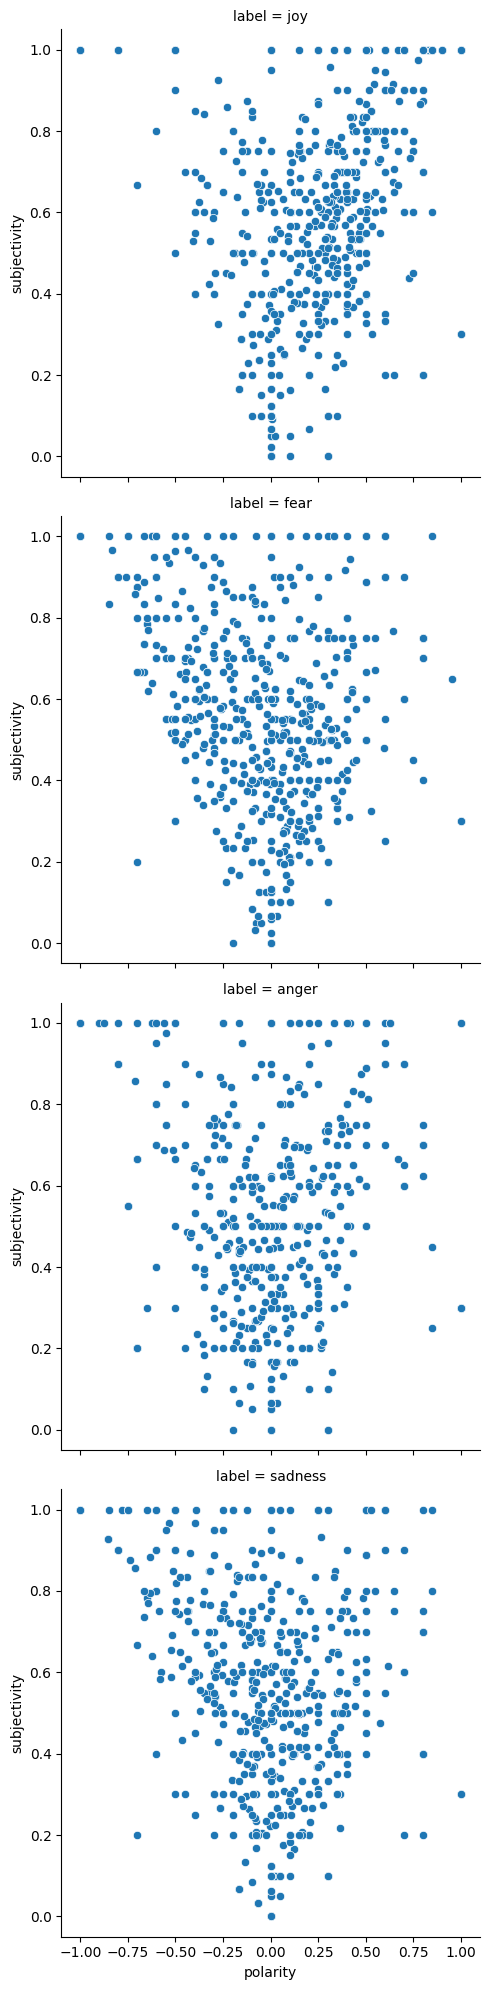

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 20))
sns.relplot(data=train, x='polarity', y='subjectivity', row='label')

In [32]:
import numpy as np
def words_reduction(x):
    a = re.findall(r'[\w\d]+', x)
    b = str()
    for i in a:
        b = b + str(' ') + str(i)
    return b

def searching_vector(x):
    nlp_x = nlp(x)
    vec_x = nlp_x.vector
    if len(vec_x) == 0:
        vec_x = np.zeros([1, 96])
    return vec_x

def get_words_vector(x):
    text_vector = searching_vector(words_reduction(x[0]))
    for t in x[1:]:
        new_vector = searching_vector(words_reduction(t))
        text_vector = np.vstack((text_vector, new_vector))
    return text_vector

train_text_vector = get_words_vector(train.text)

In [33]:
from sklearn.preprocessing import LabelEncoder

target_transformer = LabelEncoder()
train_label_transformed = target_transformer.fit_transform(np.array(train.label).reshape(-1, 1))

In [35]:
valid=val


In [36]:
def words_reduction(x):
    a = re.findall(r'[\w\d]+', x)
    b = str()
    for i in a:
        b = b + str(' ') + str(i)
    return b

def searching_vector(x):
    nlp_x = nlp(x)
    vec_x = nlp_x.vector
    if len(vec_x) == 0:
        vec_x = np.zeros([1, 96])
    return vec_x

def get_words_vector(x):
    text_vector = searching_vector(words_reduction(x[0]))
    for t in x[1:]:
        new_vector = searching_vector(words_reduction(t))
        text_vector = np.vstack((text_vector, new_vector))
    return text_vector

train_text_vector = get_words_vector(train.text)

In [37]:
from sklearn.preprocessing import LabelEncoder

target_transformer = LabelEncoder()
train_label_transformed = target_transformer.fit_transform(np.array(train.label).reshape(-1, 1))

In [38]:
valid_text_vector = get_words_vector(valid.text)
valid_label_transformed = target_transformer.transform(np.array(valid.label).reshape(-1, 1))

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [40]:
models = [LogisticRegression(), GaussianNB(), SVC(), KNeighborsClassifier(),
          DecisionTreeClassifier(), RandomForestClassifier(), AdaBoostClassifier()]
model_names = ['Logistic Regression', 'Gaussian Naive-Bayes', 'SVC', 'K-Neighbors Classifier',
               'Decision Tree Classifier', 'Random Forest Classifier', 'Ada Boost Classifier']
scores = np.zeros([len(models), 1])

for i, m in enumerate(models):
    clf =  m.fit(train_text_vector, train_label_transformed)
    scores[i] = clf.score(valid_text_vector, valid_label_transformed)

scores = pd.DataFrame(scores, columns=['score'], index=model_names)
scores

,score
Logistic Regression,0.317003
Gaussian Naive-Bayes,0.308357
SVC,0.342939
K-Neighbors Classifier,0.308357
Decision Tree Classifier,0.276657
Random Forest Classifier,0.328530
Ada Boost Classifier,0.288184


In [41]:
from sklearn.preprocessing import OneHotEncoder

oh_transformer = OneHotEncoder()
train_oh_label = oh_transformer.fit_transform(np.array(train.label).reshape(-1, 1))
train_oh_label = train_oh_label.toarray()

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='relu'))
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [43]:
model.fit(train_text_vector, train_oh_label, epochs=30, batch_size=42)

Epoch 1/30
87/87 [==============================] - 3s 8ms/step - loss: nan - accuracy: 0.2402
Epoch 2/30
87/87 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.2372
Epoch 3/30
87/87 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.2372
Epoch 4/30
87/87 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.2372
Epoch 5/30
87/87 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.2372
Epoch 6/30
87/87 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.2372
Epoch 7/30
87/87 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.2372
Epoch 8/30
87/87 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.2372
Epoch 9/30
87/87 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.2372
Epoch 10/30
87/87 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.2372
Epoch 11/30
87/87 [==============================

In [44]:
def get_the_parts(txt):
    long = len(txt)
    important = ['ADJ', 'VERB', 'NOUN']
    the_parts = []
    for t in txt:
        if t.pos_ in important:
            the_parts.append(str(t))
    parts_text = str()
    for t in the_parts:
        parts_text = parts_text + ' ' + t
    return parts_text

new_texts = [get_the_parts(nlp(words_reduction(x))) for x in train.text]
new_vec = get_words_vector(new_texts)

In [45]:
new_valids = [get_the_parts(nlp(words_reduction(x))) for x in valid.text]
new_valids_vec = get_words_vector(new_valids)

In [46]:
scores_2 = np.zeros([len(models), 1])

for i, m in enumerate(models):
    clf =  m.fit(new_vec, train_label_transformed)
    scores_2[i] = clf.score(new_valids_vec, valid_label_transformed)

scores_2 = pd.DataFrame(scores_2, columns=['score'], index=model_names)
scores_2

,score
Logistic Regression,0.328530
Gaussian Naive-Bayes,0.268012
SVC,0.334294
K-Neighbors Classifier,0.268012
Decision Tree Classifier,0.239193
Random Forest Classifier,0.293948
Ada Boost Classifier,0.250720


In [48]:
sketch = new_texts
no_space = lambda x: x.lower()
new_texts = [no_space(x) for x in sketch]

sketch_valid = [words_reduction(x) for x in valid.text]
new_valid = [no_space(x) for x in sketch_valid]

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
train_text_cv = cv.fit_transform(new_texts)
valid_text_cv = cv.transform(new_valid)

train_text_cv = train_text_cv.toarray()
valid_text_cv = valid_text_cv.toarray()

In [50]:
scores_3 = np.zeros([len(models), 1])

for i, m in enumerate(models):
    clf =  m.fit(train_text_cv, train_label_transformed)
    scores_3[i] = clf.score(valid_text_cv, valid_label_transformed)

scores_3 = pd.DataFrame(scores_3, columns=['score'], index=model_names)
scores_3

,score
Logistic Regression,0.827089
Gaussian Naive-Bayes,0.564841
SVC,0.801153
K-Neighbors Classifier,0.461095
Decision Tree Classifier,0.780980
Random Forest Classifier,0.818444
Ada Boost Classifier,0.616715


from matplotlib import pyplot as plt
scores_3['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
scores_3['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

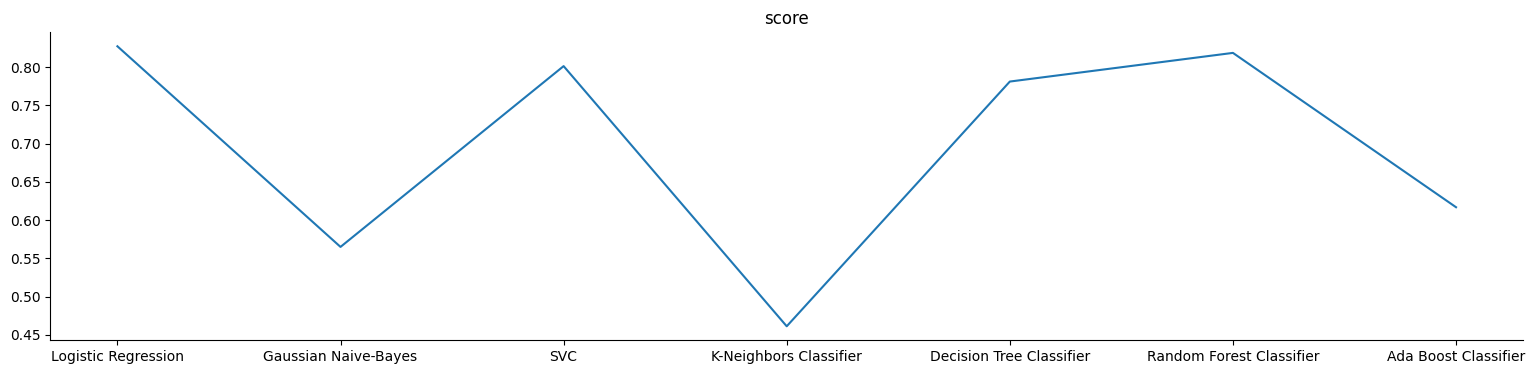

In [52]:
from matplotlib import pyplot as plt
scores_3['score'].plot(kind='line', figsize=(19, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
scores_3['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [8]:
sia = SentimentIntensityAnalyzer()

In [9]:
sentiments = []
for text in data['text']:
    sentiment = sia.polarity_scores(text)
    sentiments.append(sentiment)

In [10]:
sentiment_labels = []
for sentiment in sentiments:
    compound_score = sentiment['compound']
    if compound_score >= 0.05:
        sentiment_labels.append('Positive')
    elif compound_score <= -0.05:
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')

In [11]:
# Add the sentiment labels to the DataFrame
data['sentiment'] = sentiment_labels

In [12]:
data[['text', 'sentiment', 'label']].head(10)

,text,sentiment,label
0,Just got back from seeing @GaryDelaney in Burs...,Positive,joy
1,Oh dear an evening of absolute hilarity I don'...,Positive,joy
2,Been waiting all week for this game â¤ï¸â¤ï...,Neutral,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",Positive,joy
4,I feel so blessed to work with the family that...,Positive,joy
5,"Today I reached 1000 subscribers on YT!! , #go...",Positive,joy
6,"@Singaholic121 Good morning, love! Happy first...",Positive,joy
7,#BridgetJonesBaby is the best thing I've seen ...,Positive,joy
8,Just got back from seeing @GaryDelaney in Burs...,Positive,joy
9,@IndyMN I thought the holidays could not get a...,Positive,joy


In [13]:
from sklearn.model_selection import train_test_split
X = data[['text','sentiment']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train['sentiment'] = le.fit_transform(X_train['sentiment'])
X_test['sentiment'] = le.fit_transform(X_test['sentiment'])

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['text'])
X_test_tfidf = vectorizer.transform(X_test['text'])

In [15]:
model = SVC()
model.fit(X_train_tfidf, y_train)

SVC()

In [16]:
y_pred = model.predict(X_test_tfidf)

In [17]:
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8458831808585503
Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.83      0.84       327
        fear       0.78      0.94      0.85       432
         joy       0.96      0.87      0.91       352
     sadness       0.83      0.71      0.76       310

    accuracy                           0.85      1421
   macro avg       0.86      0.84      0.84      1421
weighted avg       0.85      0.85      0.85      1421



In [18]:
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])
    sentiment = model.predict(text_tfidf)
    return sentiment[0]

In [19]:
new_review = "Im happy"
predicted_sentiment = predict_sentiment(new_review)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: joy


In [20]:
new_review = "Im feel confussed "
predicted_sentiment = predict_sentiment(new_review)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: sadness


In [21]:
new_review = "I hate all "
predicted_sentiment = predict_sentiment(new_review)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: anger
